# Análisis económico de los unicornios uruguayos

Basándome en los cursos [Analítica financiera](https://www.coursera.org/learn/analitica-financiera) de la plataforma Coursera, propongo analizar los datos que obtengamos, desde yahoo finances, para las empresas uruguayas que han sido consideras [Unicornios](https://www.eleconomista.com.mx/tecnologia/Que-es-un-unicornio-20211015-0072.html) en el mercado Mundial.

``Unicornio Financiero``: es un término utilizado dentro de la industria de capital de riesgo para referirse a una empresa privada, es decir, que no ha salido a Bolsa, y que tiene un valor superior a los 1,000 millones de dólares.

## Preparacion de los datos

Importamos las librerias que utilizaremos

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# Ignoramos los warnings
import warnings
warnings.filterwarnings('ignore')

Cargamos los datos que utilizaremos de la empresa ``dLocal``, lo haremos con datos desde Junio del 2021, que es desde la fecha la cual yahoo posee datos sobre ella.

``dLocal Limited``: opera una plataforma de procesamiento de pagos en todo el mundo. Su plataforma de pagos permite a los comerciantes recibir pagos y realizar pagos en línea. La empresa presta servicios a las industrias de comercio, streaming, transporte compartido, servicios financieros, publicidad, software como servicio, viajes, aprendizaje electrónico, entrega bajo demanda, juegos y criptografía. DLocal Limited se fundó en 2016 y tiene su sede en Montevideo, Uruguay.

*Nota*: La empresa Uruguaya NewPorts tambien es considerada unicornio desde el 2022, lamentablemente la pagina de yahoo no tiene informacion sobre ella.

In [2]:
# Obtener los datos de dLocal
dlocal = yf.Ticker("DLO")
start = "2021-06-03"
end = "2023-09-01"
dlocal_data = dlocal.history(start=start, end=end)

In [3]:
dlocal['Date'] = dlocal['Date'].str.split().str[0]
dlocal_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-06-03 00:00:00-04:00,31.000000,33.500000,29.610001,32.389999,15482700,0.0,0.0
2021-06-04 00:00:00-04:00,30.629999,38.779999,30.540001,34.520000,3501300,0.0,0.0
2021-06-07 00:00:00-04:00,34.959999,34.970001,31.200001,34.130001,1959100,0.0,0.0
2021-06-08 00:00:00-04:00,33.450001,33.907001,30.600000,32.169998,1179100,0.0,0.0
2021-06-09 00:00:00-04:00,32.299999,32.904999,31.490000,31.510000,357300,0.0,0.0
...,...,...,...,...,...,...,...
2023-08-25 00:00:00-04:00,18.570000,19.855000,18.549999,19.480000,1279500,0.0,0.0
2023-08-28 00:00:00-04:00,19.480000,20.500999,19.469999,20.180000,2052300,0.0,0.0
2023-08-29 00:00:00-04:00,20.230000,21.420000,19.950001,20.950001,2457700,0.0,0.0


In [4]:
print(f'Nuestro dataframe posee {dlocal_data.shape[0]} datos (desde la fecha {start} hasta {end}) y {dlocal_data.shape[1]} variables')

Nuestro dataframe posee 566 datos (desde la fecha 2021-06-03 hasta 2023-09-01) y 7 variables


Solo utilizaremos dos columnas, Precios de Cierre (Close) y Volúmenes tranzados (Volumne)

In [5]:
dlocal_data = dlocal_data.iloc[:,[3,4]]
dlocal_data.columns

Index(['Close', 'Volume'], dtype='object')

Analicemos si posee datos nulos

In [6]:
dlocal_data.isna().nunique()

Close     1
Volume    1
dtype: int64

Guardamos el nuevo DataFrame para no tener que descargar los datos nuevamente

In [7]:
dlocal_data.to_csv('dlocal_data.csv', sep=",")

#### Graficamos la serie de tiempo de los precios, primero ajustamos los parametros del modulo, luego creamos una funcion para graficar la serie y por ultimo la graficamos

In [8]:
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

Nota: Estandarizamos los datos para visualizarlos de manera mas clara

In [9]:
def serie_temporal():
    # Crear una figura y un conjunto de ejes
    _, ax = plt.subplots(figsize=(10, 6))

    # Graficar las dos variables simultáneas
    ax.plot(dlocal_data.index, MinMaxScaler().fit_transform(dlocal_data["Close"].to_numpy().reshape(-1, 1)), label='precio')
    ax.plot(dlocal_data.index, MinMaxScaler().fit_transform(dlocal_data["Volume"].to_numpy().reshape(-1, 1)), label='Volumen')

    # Agregar etiquetas de los ejes y el título
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Valor')
    ax.set_title('Evolucion dLocal')

    # Agregar una leyenda
    ax.legend()

    # Mostrar el gráfico
    plt.show()


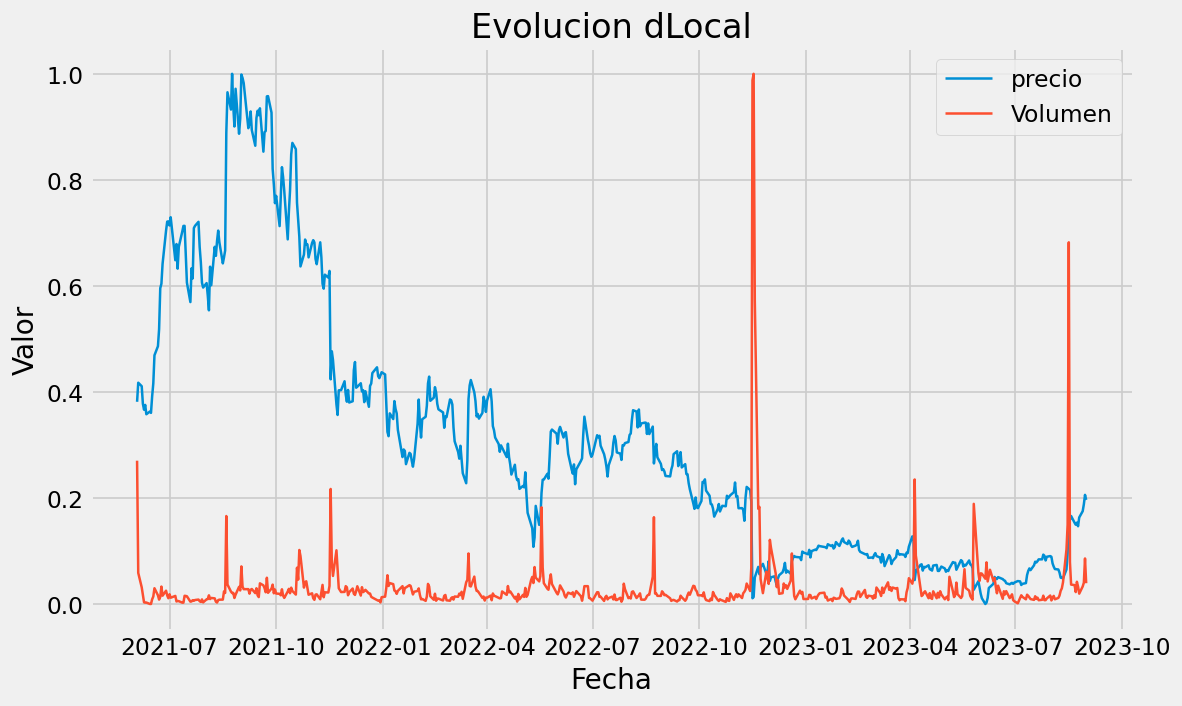

In [10]:
serie_temporal()

*Podemos decir que no se encuentra una relacion entre el precio y el volumen tranzado*

Dividimos la serie Close (Precio de cierre), tomemos el 20% para la prueba y el restante 80% para entrenar el modelo

In [11]:
h = int(round(len(dlocal_data)*0.20))
train = dlocal_data['Close'].iloc[:-h]
test = dlocal_data['Close'].iloc[-h:]

## Modelos ARIMA

Un modelo **ARIMA** es un modelo estadístico que se utiliza para predecir series temporales. Es un acrónimo de autoregressive integrated moving average, que significa autorregresivo integrado de media móvil. Se basan en la idea de que una serie temporal se puede modelar como una combinación de tres componentes:

* ``Componente autorregresivo``. Este componente representa la dependencia de los valores actuales de la serie temporal de los valores anteriores.
* ``Componente integrado``. Este componente representa la tendencia de la serie temporal a crecer o decrecer a lo largo del tiempo.
* ``Componente de media móvil``. Este componente representa la influencia de los errores aleatorios en los valores de la serie temporal.

Primero analizemos la estacionaridad de la serie mediante una prueba Dickey-Fuller aumentada.

ADF Statistic: -1.113600
p-value: 0.709618
	1%: -3.445
	5%: -2.868
	10%: -2.570

La serie no es estacionaria. Se necesita diferenciar la serie.

ADF Statistic: -10.607678
p-value: 0.000000
	1%: -3.445
	5%: -2.868
	10%: -2.570


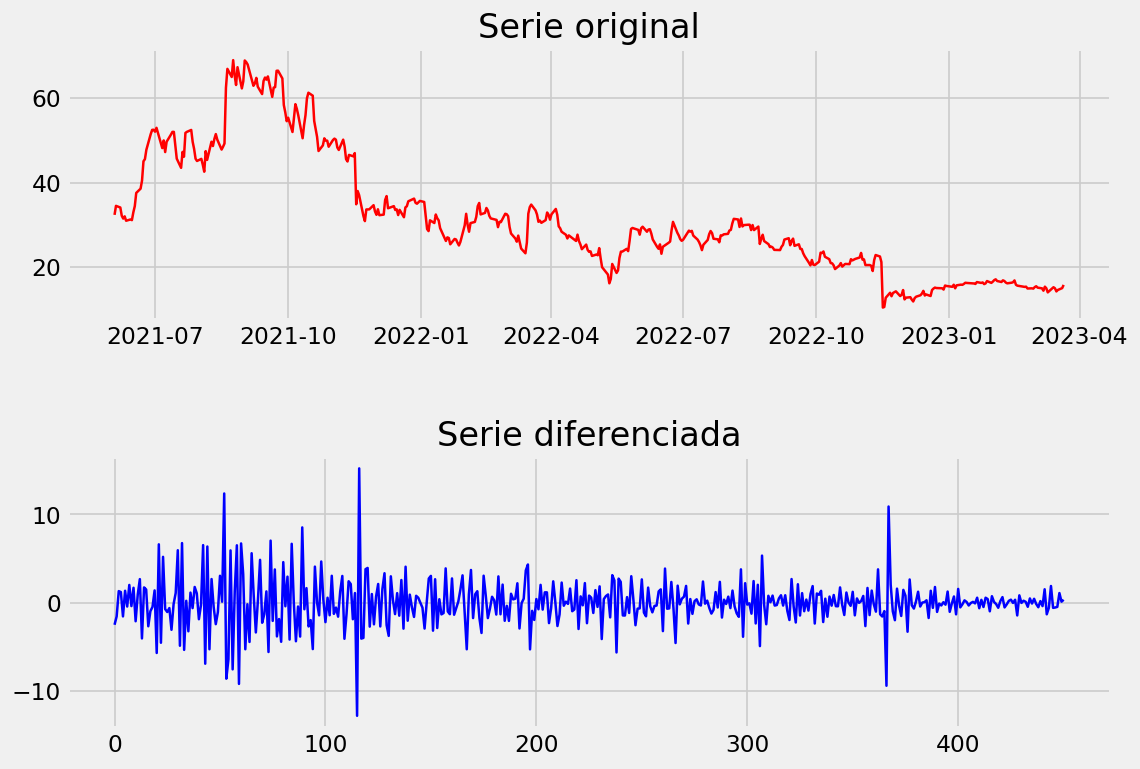

El coeficiente d:  1


In [12]:
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
d = 0
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] > result[4]["5%"]:
  while result[0] > result[4]["5%"]:
    d += 1
    print()
    print("La serie no es estacionaria. Se necesita diferenciar la serie.")
    dtrain = np.diff(train, n=d+1)
    result = adfuller(dtrain)
    print()
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    ## Graficas de ambos
    fig, ax = plt.subplots(2,1)
    ax[0].plot(train, color="red")
    ax[0].set_title("Serie original")
    ax[1].plot(dtrain, color="blue")
    ax[1].set_title("Serie diferenciada")
    plt.subplots_adjust(hspace=0.5)
    plt.show()

else:
  print("La serie es estacionaria.")
  dtrain = train

print('El coeficiente d: ', d)

Una vez tenemos la serie ya estacionaria (en dtrain), graficamos las autocorrelaciones para determinar los coeficientes ar y ma

<Figure size 1440x720 with 0 Axes>

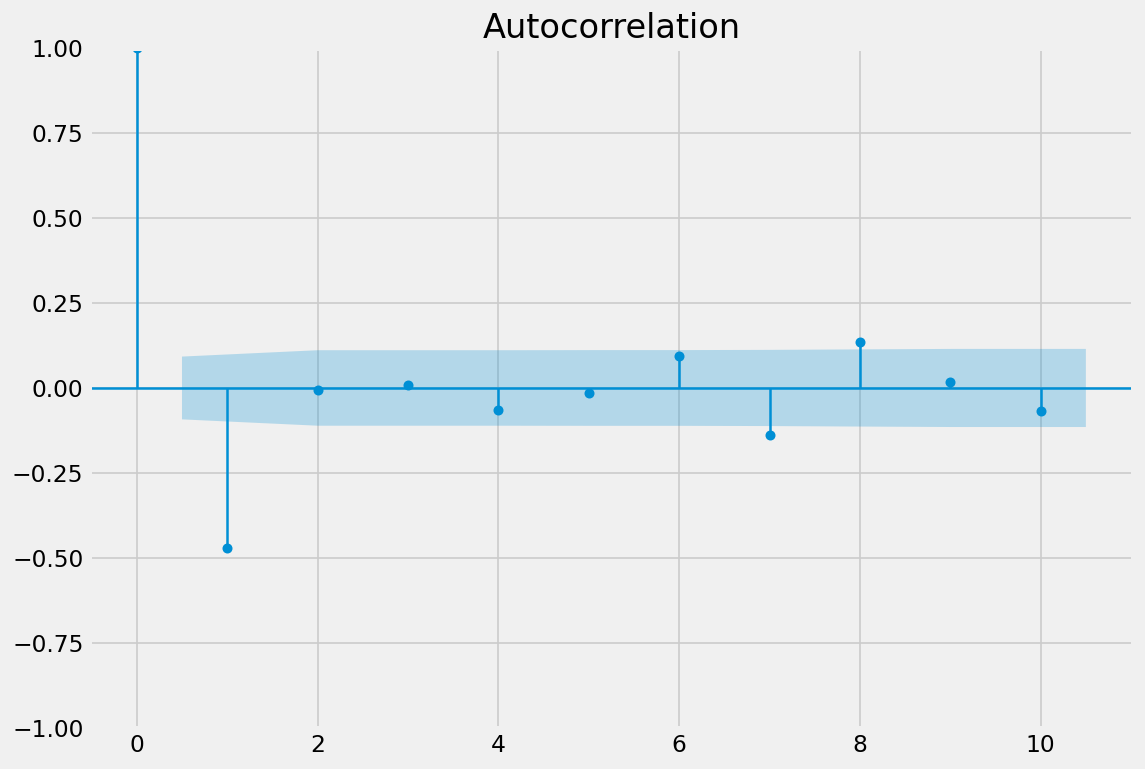

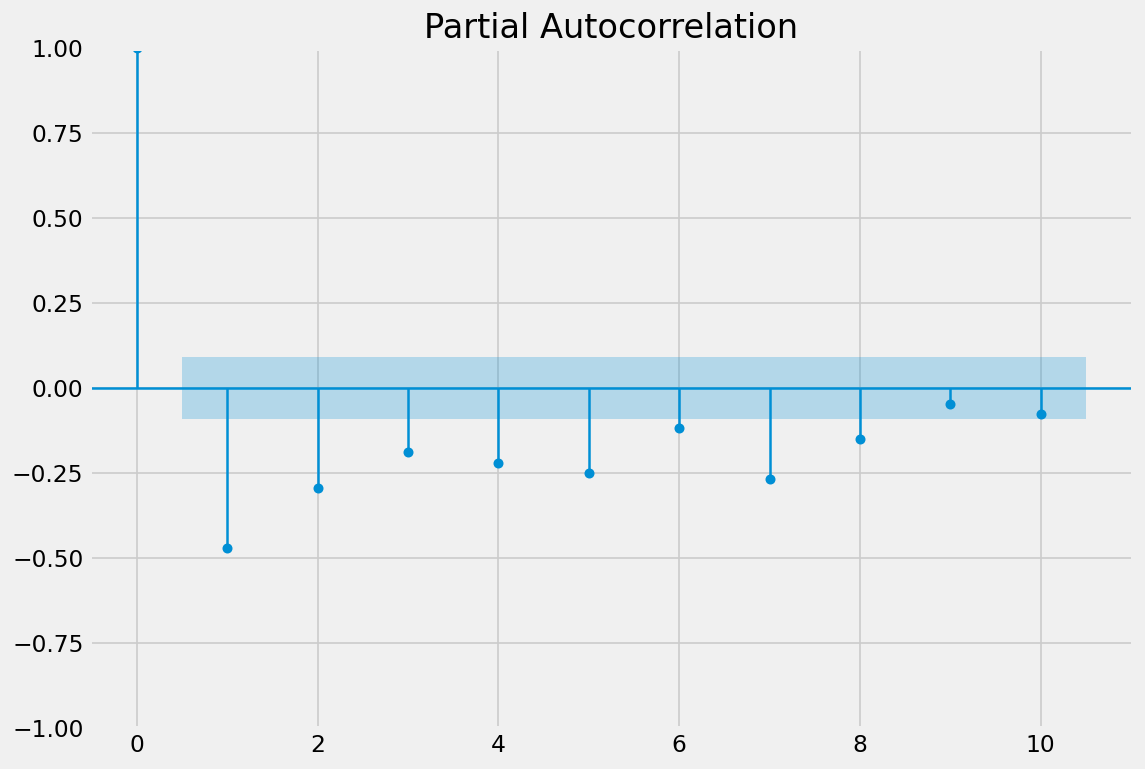

In [13]:
plt.figure(figsize=(12,6))
plot_acf(dtrain, lags=10)
plot_pacf(dtrain, lags=10)
plt.show()

Segun las graficas acf y pacf anteriores, eh decidido probar con un ``ar`` de 2 periodos y tres opciones ``ma`` de 2, 3 y 4 periodos.

In [14]:
model_1 = ARIMA(train, order=(2,1,2)).fit()
model_2 = ARIMA(train, order=(2,1,3)).fit()
model_3 = ARIMA(train, order=(2,1,4)).fit()

Vizualizamos las estadisticas de cada modelo

In [15]:
print(model_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  453
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -936.407
Date:                Sat, 09 Sep 2023   AIC                           1882.813
Time:                        22:16:23   BIC                           1903.382
Sample:                             0   HQIC                          1890.919
                                - 453                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3284      0.009    155.895      0.000       1.312       1.345
ar.L2         -0.9943      0.008   -125.843      0.000      -1.010      -0.979
ma.L1         -1.3025      0.019    -67.105      0.0

In [16]:
print(model_2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  453
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -935.731
Date:                Sat, 09 Sep 2023   AIC                           1883.462
Time:                        22:16:23   BIC                           1908.144
Sample:                             0   HQIC                          1893.189
                                - 453                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3371      0.009    144.052      0.000       1.319       1.355
ar.L2         -0.9933      0.008   -125.449      0.000      -1.009      -0.978
ma.L1         -1.3304      0.042    -31.989      0.0

In [17]:
print(model_3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  453
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -940.201
Date:                Sat, 09 Sep 2023   AIC                           1894.402
Time:                        22:16:23   BIC                           1923.198
Sample:                             0   HQIC                          1905.750
                                - 453                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2928      0.541      0.541      0.588      -0.768       1.353
ar.L2         -0.1460      0.393     -0.371      0.711      -0.917       0.625
ma.L1         -0.2692      0.544     -0.495      0.6

*NOTA: A primera vista vemos que los modelos 2 y 3 poseen parametros no significativos (el ma(3) y el ma(4) con un P>|z| mayor a 0.05) por lo que podriamos descartar estos modelos y quedarnos con nuestra primer opcion, de todas maneras analizemos los modelos mediante los errores*

Usamos los datos de test para predecir y evaluar los modelos

In [18]:
pred1 = model_1.get_forecast(steps=h)
pred2 = model_2.get_forecast(steps=h)
pred3 = model_3.get_forecast(steps=h)

Evaluamos los modelos mediante mse (mean squared error o media de los errores al cuadrado)

In [19]:
print('ARIMA(2,1,2) MSE: ', mean_squared_error(test, pred1.predicted_mean))
print('ARIMA(2,1,3) MSE: ', mean_squared_error(test, pred2.predicted_mean))
print('ARIMA(2,1,4) MSE: ', mean_squared_error(test, pred3.predicted_mean))

ARIMA(2,1,2) MSE:  8.221314425681634
ARIMA(2,1,3) MSE:  8.411950459132752
ARIMA(2,1,4) MSE:  7.545993711378166


**Conclusion**: Confirmamos lo que habiamos dicho anteriormente, el primer modelo que planteamos ``arima(2,1,2)`` es el que presenta la mejor evaluacion

## Predecimos hacia adelante

Trataremos de predecir el valor de "Close" para un periodo de una semana. Para ellos hare la predicción y posteriormente obtendre los datos la proxima semana para evaluar si las predicciones son buenas.

In [21]:
# Hacer predicciones hacia adelante (5 pasos hacia adelante, 5 días hábiles)
n_steps = 5
forecast = model_1.forecast(steps=n_steps)

In [22]:
forecast

453    15.954963
454    16.029587
455    15.994523
456    15.873744
457    15.748166
Name: predicted_mean, dtype: float64

Obtenemos los nuevos datos

In [23]:
# Obtener los datos de dLocal
dlocal = yf.Ticker("DLO")
start = "2023-09-01"
end = "2023-09-09"
dlocal_new = dlocal.history(start=start, end=end)

Los guardamos en csv

In [24]:
dlocal_new.to_csv('dlocal_new.csv', sep=",")

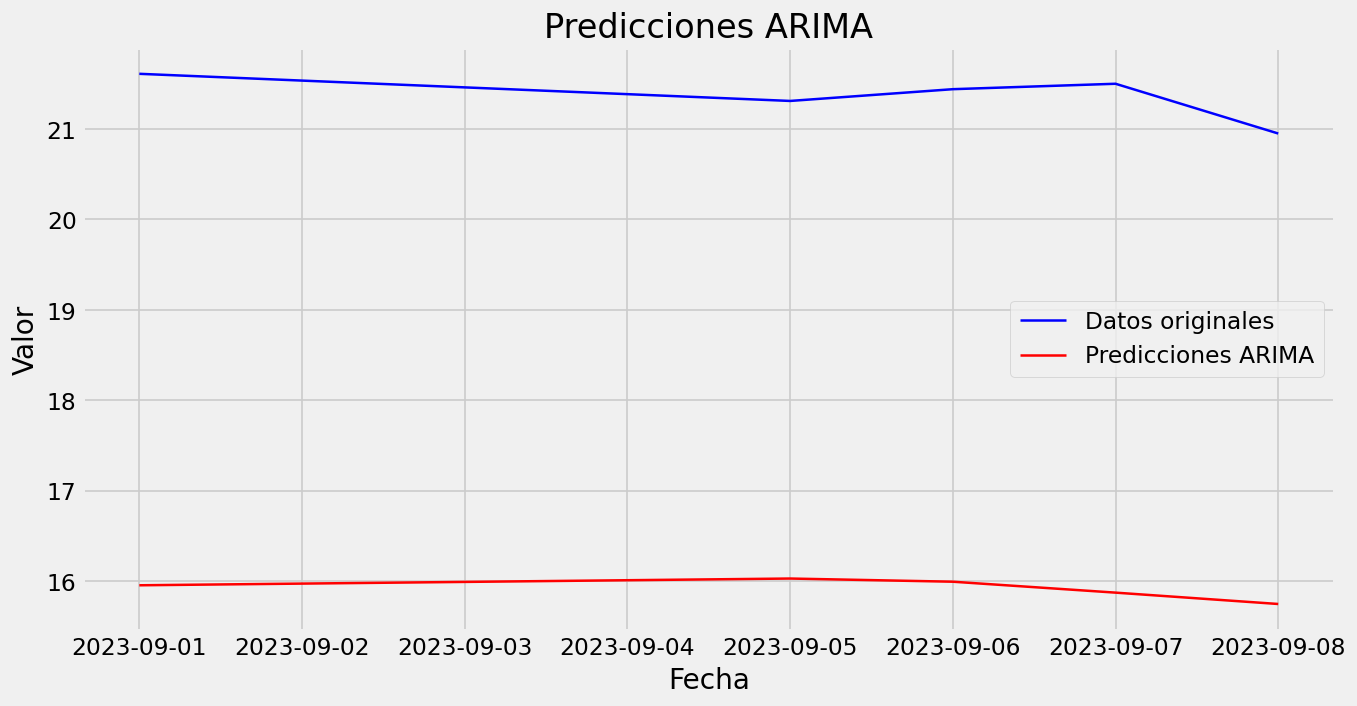

In [25]:
# Visualizar los datos originales y las predicciones
plt.figure(figsize=(12, 6))
plt.plot(dlocal_new.index, dlocal_new['Close'], label='Datos originales', color='blue')
plt.plot(dlocal_new.index, forecast, label='Predicciones ARIMA', color='red')
plt.legend(loc='best')
plt.title('Predicciones ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.show()